In [1]:
#%pip install gurobipy

In [2]:
%pip install pulp

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#import gurobipy as gp
#from gurobipy import GRB, Model, quicksum

import pulp

import numpy as np
import matplotlib.pyplot as plt

import itertools

## Creazione dei dati

In [4]:
# Numero casuale
rnd = np.random
rnd.seed(0)

In [5]:
n = 50    # Numero punti vendita
# Bisogna ricordare che il nodo deposito, nella nostra formulazione, corrisponde a D={'s', 't'}
  # con 's' visto come nodo deposito per l'uscita dei veicoli e 'v' come nodo deposito per entrata
# Di conseguenza, poniamo 's'=xc[0] e 't'=xc[n+1]
xc = rnd.rand(n+1)*200      # Vettore di coordinate x dei vari nodi
xc = np.append(xc, xc[0])   # Coordinate x di 't' devono essere uguali alle coordinate x di 's'
yc = rnd.rand(n+1)*100      # Vettore di coordinate y dei vari nodi
yc = np.append(yc, yc[0])   # Coordinate y di 't' devono essere uguali alle coordinate y di 's'

In [6]:
# CREAZIONE DATI

P = [il for il in range(1,n+1)]         # Insieme P dei punti vendita
N = [0] + P + [n+1]                     # Insieme N dei nodi, come unione di P e D={'s','t'}
                                          # 's' corrisponde al nodo 0, mentre 't' corrisponde al nodo n+1

# Insieme A degli archi
# Devo controllare che il nodo i sia differente da j. Inoltre, devo anche controllare di non includere
  # gli archi ('s','t') e ('t','s') poichè sia 's' che 't' corrispondono al nodo deposito
A = [(i,j) for i in N for j in N if i!=j and (i,j)!=(n+1,0) and (i,j)!=(0,n+1)]

# Costi associati a ogni arco
c = {(i,j): np.random.randint(2,15) for i,j in A}

# Tempo di percorrenza degli archi
# Per semplicità ho posto il tempo di percorrenza come la distanza tra i nodi i e j
t = {(i,j): int(np.hypot(xc[i]-xc[j], yc[i]-yc[j])) for i,j in A}

# Richiesta per ogni nodo
np.random.seed(0)
d = {i: np.random.randint(10,15) for i in P}
d[0] = 0                                    # Nodo deposito 's'
d[n+1] = 0                                  # Nodo deposito 't'

# Finestre di apertura dei punti di vendita
a = {}
b = {}
# Orari depositi
a[0], b[0] = 0, 1500
a[n+1], b[n+1] = 0, 1500
# Divisione in 3 fasce orario: {[20,480], [50,900], [710, 1450]}
for i in P:
    r = i % 3
    if r == 1:
        a[i], b[i] = 20, 560
    elif r == 2:
        a[i], b[i] = 50, 1200
    else:
        a[i], b[i] = 710, 1450

V = list(range(1, 11))                      # Insieme V dei veicoli
Q = {1:90, 2:90, 3:80, 4:80, 5:90, 6:90,    # Insieme Q delle capacità massime dei veicoli
     7:80, 8:80, 9:90, 10:100}              

# Tempo di servizio
s = {(i,k): np.random.randint(3,5) if i!=0 and i!=n+1 else 0 for i in N for k in V}

In [7]:
print(P)
print(N)
print(xc)
print(yc)
print(A)
print(c)
print(t)
print(d)
print(a)
print(b)
print(s)
print(V)
print(Q)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
[109.76270079 143.03787327 120.55267521 108.9766366   84.73095987
 129.17882261  87.51744225 178.35460016 192.7325521   76.68830377
 158.34500762 105.77898395 113.60891222 185.11932766  14.20721164
  17.42585994   4.04367949 166.52396911 155.63135019 174.00242965
 195.72366845 159.83171284  92.29587245 156.10583526  23.65488517
 127.98420427  28.67065748 188.93378341 104.36966435  82.932388
  52.91112242 154.84673789  91.23006644 113.68678977   3.75796009
 123.52709942 122.41914454 123.38679937 188.7496157  136.36405982
  71.90158011  87.40639076 139.52623919  12.04509433 133.35334309
 134.12757392  42

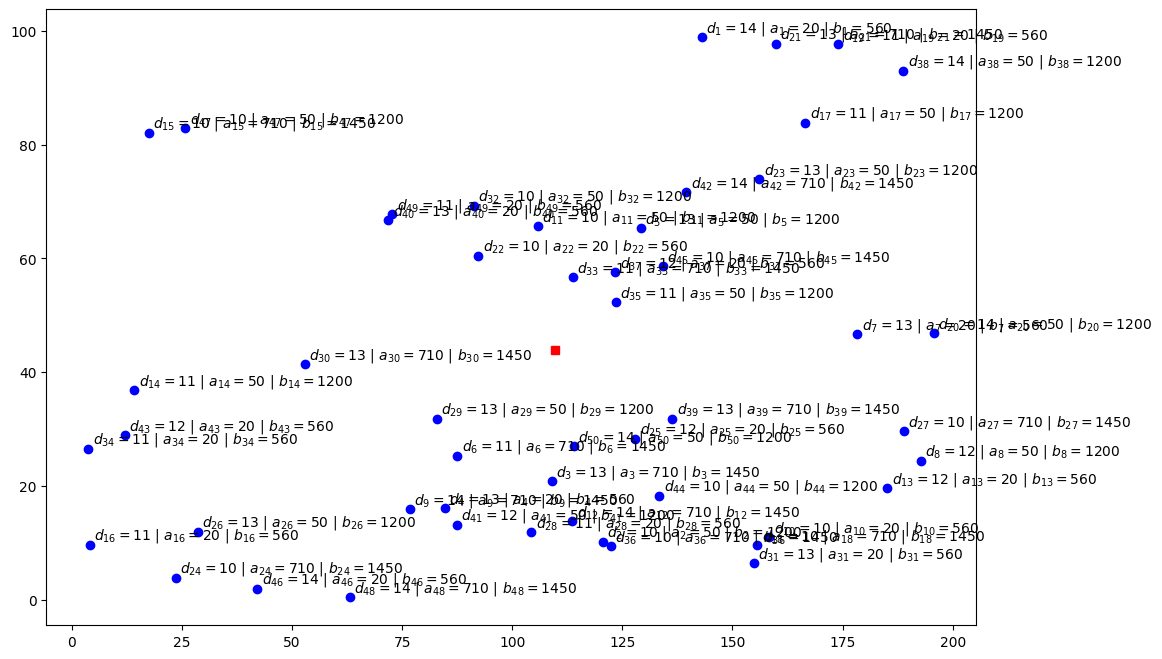

In [8]:
# Visualizzazione deposito e punti vendita
plt.figure(figsize=(12,8))
plt.plot(xc[0], yc[0], c='r', marker='s')     # Nodo deposito
plt.scatter(xc[1:n+1], yc[1:n+1], c='b')          # Nodi punti vendita
for i in P:
  plt.annotate("$d_{%i}=%d$ | $a_{%i}=%d$ | $b_{%i}=%d$" %(i, d[i], i, a[i], i, b[i]), (xc[i]+1, yc[i]+1))

## Algoritmo esatto PuLP


In [9]:
# Creazione archi per il modello
arco_var = [(i,j,k) for i in N for j in N for k in V if i!=j and (i,j)!=(n+1,0) and (i,j)!=(0,n+1)]
arco_arrivo = [(i,k)for i in N for k in V]

In [10]:
# Modello
model = pulp.LpProblem("VRPTW", pulp.LpMinimize)

# Variabili di decisione
x = pulp.LpVariable.dicts("x", arco_var, cat="Binary")
l = pulp.LpVariable.dicts("x", arco_arrivo, lowBound = 0, cat="Continuous")

# Funzione obiettivo
model += pulp.lpSum(c[i,j]*x[i,j,k] for (i,j,k) in arco_var)

In [ ]:
# Vincoli

# Vincolo di capacità
for k in V:
  model += pulp.lpSum(d[i]*x[i,j,k] for i in P for j in N if i!=j) <= Q[k]

# Vincolo di unicità dei punti di vendita
for i in P:
  model += pulp.lpSum(x[i,j,k] for j in N for k in V if (i,j) if i!=j) == 1

# Vincolo sulla partenza e arrivo del singolo veicolo
for k in V:
  model += pulp.lpSum(x[0,j,k] for j in P) == 1         # <=1 (senza partenza obbligatoria di tutti i veicoli)
  model += pulp.lpSum(x[i,n+1,k] for i in P) == 1       # <=1 (senza partenza obbligatoria di tutti i veicoli)

# Vincolo di coerenze partenza-arrivo
for k in V:
  model += pulp.lpSum(x[0,j,k] for j in P) == pulp.lpSum(x[i,n+1,k] for i in P)

# Vincolo sul flusso dei punti vendita
for j in P:
  for k in V:
    model += pulp.lpSum(x[i,j,k] for i in N if i!=j) == pulp.lpSum(x[j,i,k] for i in N if i!=j)

# Vincolo sui sottogiri
for r in range(2, len(P)+1):        # Sottoinsiemi di cardinalità >=2
  for S in itertools.combinations(P,r):
    for k in V:
      model += pulp.lpSum(x[i,j,k] for i in S for j in S if i!=j and (i,j)!=(n+1,0) and (i,j)!=(0,n+1)) <= len(S)-1

# Vincolo di inizio servizio
M = 10000000
for k in V:
  for j in N:
    for i in N:
      if i!=j and (i,j)!=(n+1,0) and (i,j)!=(0,n+1):
        model += l[j,k] >= (l[i,k]+s[i,k]+t[i,j]) - M*(1-x[i,j,k])


# Vincolo sulla finestra temporale
for (i, k) in arco_arrivo:
    model += l[i,k] >= a[i]
    model += l[i,k] <= b[i]

# Inizializzazione del deposito
for k in V:
  l[0,k] = a[0]

model.solve()

print("Costo: ", pulp.value(model.objective))

In [ ]:
for k in V:
  print(f"\nPercorso veicolo {k}:")
  for (i,j) in A:
    if x[i,j,k].varValue == 1:
      print(f"  {i} → {j}")

In [ ]:
# Colori per i veicoli
colori = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'yellow', 'grey', 'black', 'cyan']

plt.figure(figsize=(10, 8))

# Disegna i nodi
for i in N:
  plt.plot(xc[i], yc[i], 'ko')
  plt.text(xc[i]+1, yc[i]+1, str(i), fontsize=9)

# Disegna gli archi attivi per ogni veicolo
for k in V:
  for (i, j) in A:
    if x[i, j, k].varValue == 1:
      plt.plot([xc[i], xc[j]], [yc[i], yc[j]], color=colori[k-1], linewidth=2, label=f'Veicolo {k}')

# Evita duplicati nella legenda
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title("Percorsi veicoli VRPTW")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()